<h1><center> Coastal Low-Level Jet analysis  </center></h1>
<div style="text-align: center"> 
    Dr. Harish Baki <br/> Postdoctoral researcher <br/> TU Delft, Netherlands <br/> Email: h.baki@tudelft.nl<br/>
</div>

In [1]:
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2024-06-06 21:50:37


In [2]:
import xarray as xr
from netCDF4 import Dataset
import os
import glob
import dask.distributed as dd
import dask
from dask import delayed
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product
import math

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

import seaborn as sns
import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates


root_dir = '/media/harish/SSD_4TB/EU_SCORES_project/CLLJ'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)

from data_processing.libraries import *

In [3]:
import dask.distributed as dd
if 'client' in locals():
    client.close()
    cluster.close()
cluster = dd.LocalCluster(n_workers=48, threads_per_worker=2, memory_limit='2GB',dashboard_address=f':8787')
client = dd.Client(cluster)
print(client)

2024-06-06 21:50:45,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6nyeu4lh', purging
2024-06-06 21:50:45,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-o2ilffkx', purging


<Client: 'tcp://127.0.0.1:37525' processes=48 threads=96, memory=89.41 GiB>


In [124]:
from matplotlib.ticker import MultipleLocator
def plot_wind_profile(ax, data, levels, color,line_style, marker, label, xlabel, ylabel, title, xticks, yticks):
    ax.plot(data, levels, line_style, color=color, marker=marker, label=label, markersize=4, linewidth=2)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.xaxis.set_minor_locator(MultipleLocator(1))  # Set minor ticks at every 1 value
        ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)  # Hide minor tick labels
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

    return ax

Closest indices in the order of latitude (y) and longitude (x) are : (383, 279)
Closest indices in the order of latitude (y) and longitude (x) are : (383, 277)
Closest indices in the order of latitude (y) and longitude (x) are : (383, 276)
Closest indices in the order of latitude (y) and longitude (x) are : (384, 274)
Closest indices in the order of latitude (y) and longitude (x) are : (384, 273)
Closest indices in the order of latitude (y) and longitude (x) are : (384, 271)
Closest indices in the order of latitude (y) and longitude (x) are : (385, 270)
Closest indices in the order of latitude (y) and longitude (x) are : (385, 268)
Closest indices in the order of latitude (y) and longitude (x) are : (385, 267)
Closest indices in the order of latitude (y) and longitude (x) are : (386, 265)


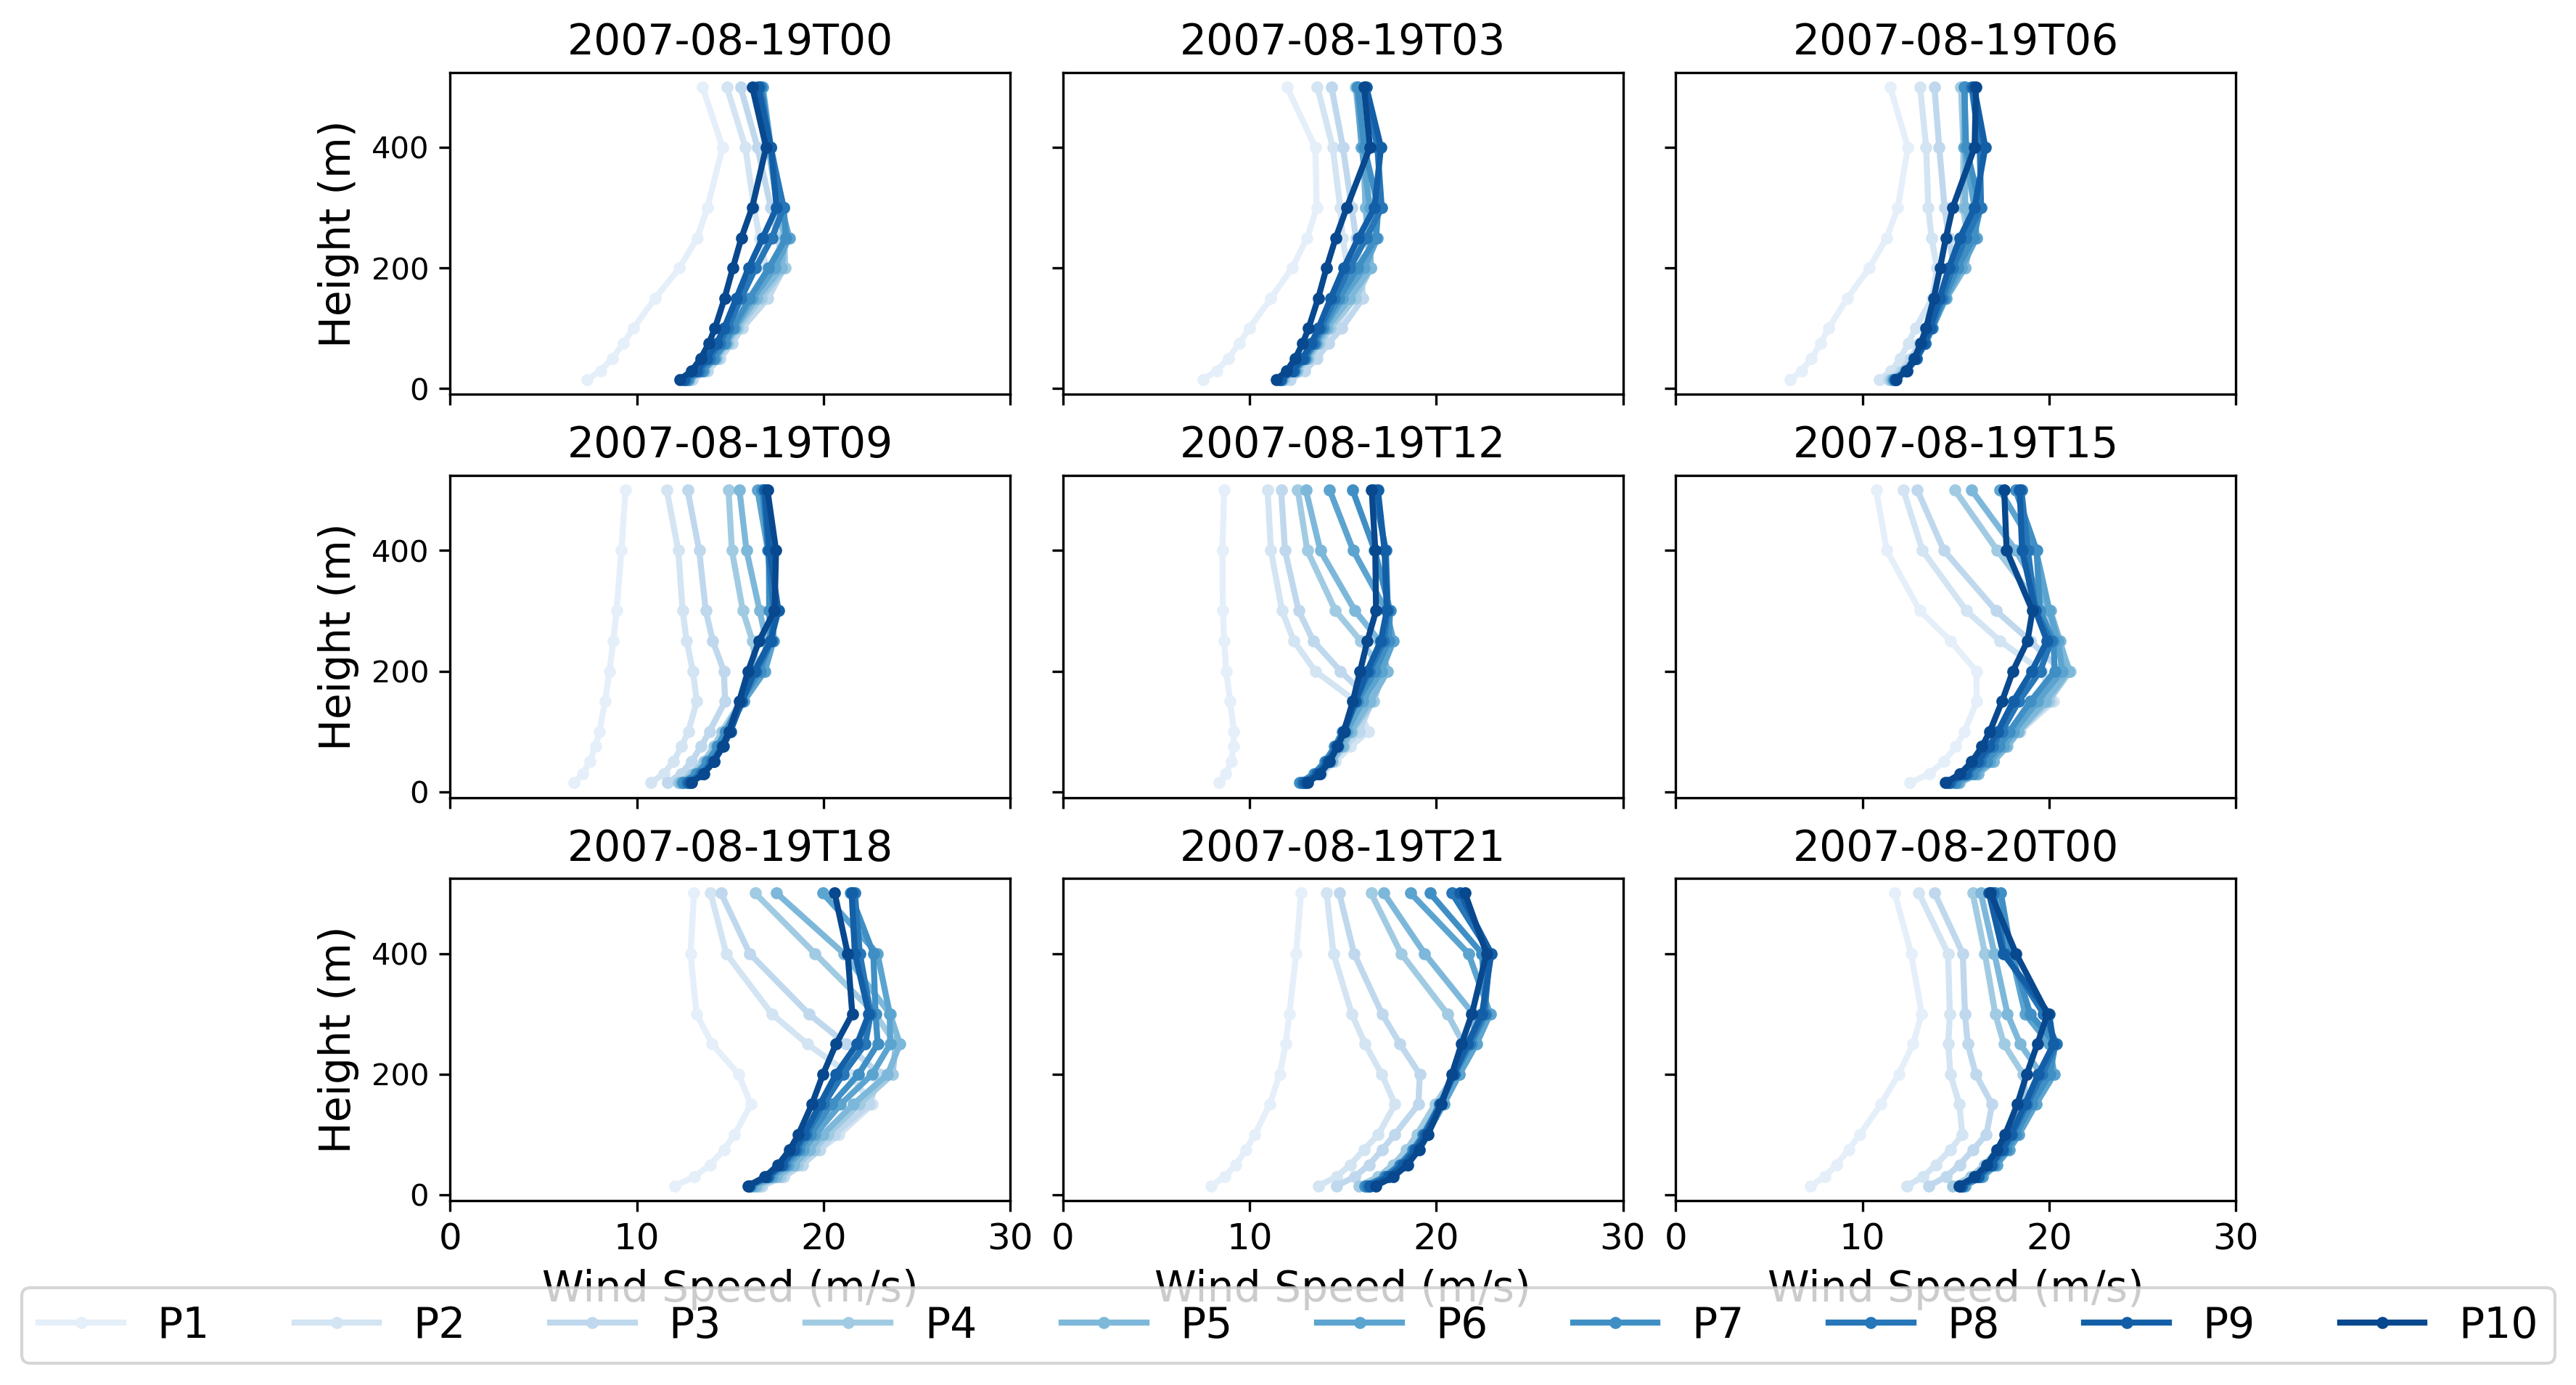

In [125]:
P1 = [41.132,-8.7]
P2 = [41.5236, -9.055]
P6 = [41.5236, -8.9]
# Create 10 locations based on P2
locations = {f'P{i+1}': (P1[0], P1[1] - 0.1 * i) for i in range(10)}
colors = sns.color_palette("Blues", 10)

CERRA = xr.open_dataset(f'{root_dir}/adaptor.mars.external-1717416871.9369903-30931-4-627944f6-236f-4fd4-8fb4-f4519a494ee8.nc')
fig, ax = plt.subplots(3,3,figsize=(9, 6), constrained_layout=True, dpi=300, sharex=True, sharey=True)
ax = ax.flatten()
for color, loc in zip(colors, locations.keys()):
    indices = find_nearest_indice(CERRA.latitude,CERRA.longitude,target_lat = locations[loc][0], target_lon = locations[loc][1])
    ws = CERRA.ws.isel(y=indices[0],x=indices[1])
    for i in range(9):
        data = ws.isel(time=i)
        ax[i].plot(data.values, data.heightAboveGround,'.-',color=color,linewidth=2,label=loc)
        ax[i].set_title(f"{data.time.values.astype('datetime64[s]').astype(datetime).strftime('%Y-%m-%dT%H')}",fontsize=14)
        ax[i].set_xlabel('Wind Speed (m/s)', fontsize=14)
        ax[i].set_ylabel('Height (m)', fontsize=14)
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].label_outer()
        ax[i].set_xlim(0,30)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
    #plt.savefig(f'/home/harish/Dropbox/Apps/Overleaf/Assessment of Wind Energy Resources for Portugal at Super-Scale Resolution/IPCJ_profiles.pdf')

# Testing hybrid algorithm using 
- Temperature inversion from https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.7482
- wind speed falloff from https://wes.copernicus.org/articles/8/1651/2023/

In [4]:
P1 = [41.132,-8.7]
P2 = [41.5236, -9.055]
P6 = [41.5236, -8.9]
target_grid = {'min_lat': 35, 'min_lon': -11,'max_lat':44,'max_lon':-8.5}
heightAboveGround = [ 15.,  30.,  50.,  75., 100.0, 150.0, 200., 250., 300., 400., 500.]

In [11]:
files = ['CERRA_gridded_15_30_50_75_200_250_300_400_500_wind_2007_7.nc',
         'CERRA_gridded_100_m_wind_2007_7.nc',
         'CERRA_gridded_150_m_wind_2007_7.nc']
ws_rest = xr.open_dataset(f'{root_dir}/{files[0]}').ws
ws_rest = regional_extraction(ws_rest,target_grid)
#ws = ws.reindex(heightAboveGround=heightAboveGround)
ws100 = xr.open_dataset(f'{root_dir}/{files[1]}').ws
ws100 = regional_extraction(ws100,target_grid,lon_convert=True).assign_coords(longitude=ws_rest.longitude) # interestingly, the longitude values are in the order of 0 to 360
ws150 = xr.open_dataset(f'{root_dir}/{files[2]}').ws
ws150 = regional_extraction(ws150,target_grid,lon_convert=True).assign_coords(longitude=ws_rest.longitude)

# Concatenate along heightAboveGround dimension
ws = xr.concat([ws_rest, ws100, ws150], dim='heightAboveGround')
ws = ws.reindex(heightAboveGround=heightAboveGround)

temp = xr.open_dataset(f'{root_dir}/CERRA_gridded_height_level_temp_2007_7.nc').t
temp = regional_extraction(temp,target_grid)

In [19]:
lsm = xr.open_dataset(f'{root_dir}/CERRA_landseamask.nc')['lsm']
lsm = regional_extraction(lsm,target_grid,lon_convert=True)

Closest indices in the order of latitude (y) and longitude (x) are : (139, 84)


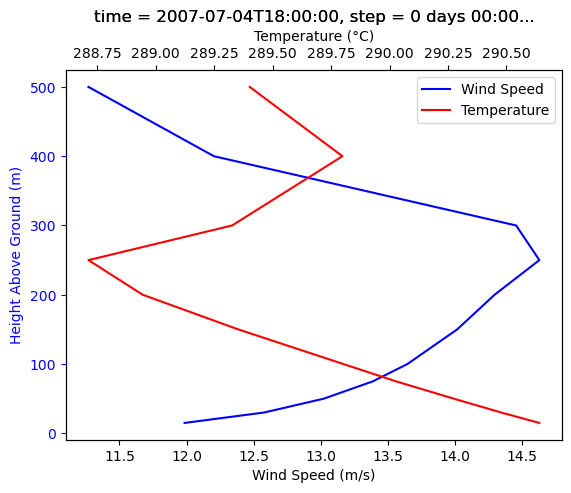

In [20]:
indices = find_nearest_indice(ws.latitude,ws.longitude,target_lat=P2[0], target_lon=P2[1],lon_convert=None)
wind_speed = ws.sel(time='2007-07-04T18').isel(y=indices[0],x=indices[1])
temperature = temp.sel(time='2007-07-04T18').isel(y=indices[0],x=indices[1])
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot wind speed with bottom x-axis
wind_speed.plot(ax=ax1, y='heightAboveGround', label='Wind Speed', color='b')
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Height Above Ground (m)', color='b')
ax1.tick_params('y', colors='b')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twiny()

# Plot temperature with top x-axis
temperature.plot(ax=ax2, y='heightAboveGround', label='Temperature', color='r')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Height Above Ground (m)', color='r')
ax2.tick_params('y', colors='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='best')

# Show plot
plt.show()

In [21]:
def detect_CLLJ_per_point(wind_speed, temperature,height,dim='heightAboveGround'):
    # Convert input arrays to xarray DataArrays if they are not already
    if not isinstance(wind_speed, xr.DataArray):
        wind_speed = xr.DataArray(wind_speed, dims=[dim], coords={dim: height})
    if not isinstance(temperature, xr.DataArray):
        temperature = xr.DataArray(temperature, dims=[dim], coords={dim: height})
    if not isinstance(height, xr.DataArray):
        height = xr.DataArray(height, dims=[dim])
    
    # 1. Core speed and core height: Local wind maximum within the lowest 1 km
    core_indice = wind_speed.argmax()
    core_speed = wind_speed.isel(heightAboveGround=core_indice)
    core_height = height.isel(heightAboveGround=core_indice)

    # 3. Fall off criteria
    below_core = wind_speed.sel(heightAboveGround=slice(None, core_height))
    above_core = wind_speed.sel(heightAboveGround=slice(core_height, None))

    increase_below = ((below_core <= core_speed - 1)).any(dim=dim) and ((below_core <= 0.9*core_speed)).any(dim=dim)
    decrease_above = ((above_core <= core_speed - 1)).any(dim=dim) and ((above_core <= 0.9*core_speed)).any(dim=dim)

    condition3 = increase_below & decrease_above

    # 4. Core height within or at the top of MABL temperature inversion
    temperature_diff = temperature.diff(dim=dim)
    inversion_base = temperature_diff.argmin(dim=dim)  # Base of the inversion
    inversion_base_height = height.isel(heightAboveGround=inversion_base)
    condition4 = core_height <= inversion_base_height

    # 5. Max temperature does not occur at the base of the MABL (reject surface-based inversion)
    max_temp_level = temperature.argmax(dim=dim)
    condition5 = max_temp_level != inversion_base

    # Combine all conditions
    cllj_condition = condition3 & condition4 & condition5

    #print(f"core high: {core_height.values},"
    #        f"core speed: {core_speed.values}, increase below: {increase_below.values}, decrease above: {decrease_above.values}," 
    #      f"condition3: {condition3.values}, inversion base height: {inversion_base_height.values}, condition4: {condition4.values}, "
    #      f"max temp level: {max_temp_level.values}, condition5: {condition5.values}, cllj: {cllj_condition.values}")
    return cllj_condition

def detect_CLLJ(wind_speed, temperature,dim='heightAboveGround'):
    height = wind_speed.coords[dim]

    # Apply the detect_CLLJ_per_point function across the dataset using Dask
    cllj_condition = xr.apply_ufunc(
        detect_CLLJ_per_point,
        wind_speed,
        temperature,
        height,
        input_core_dims=[[dim], [dim], [dim]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[bool]
    )
    
    return cllj_condition

In [ ]:
# Assuming 'data' is an xarray Dataset containing wind speed and temperature profiles
wind_speed_chunk = ws.chunk({'time':1,'y': 50, 'x': 50})
temperature_chunk = temp.chunk({'time':1,'y': 50, 'x': 50})

# Detect CLLJs
cllj_detection = detect_CLLJ(wind_speed_chunk, temperature_chunk).compute()

In [ ]:
cllj_detection.to_netcdf(f'{root_dir}/CERRA_LLJ_existence.nc')

In [31]:
cllj_detection = xr.open_dataset(f'{root_dir}/CERRA_LLJ_existence.nc')
cllj_detection = cllj_detection.rename({'__xarray_dataarray_variable__': 'cllj'})

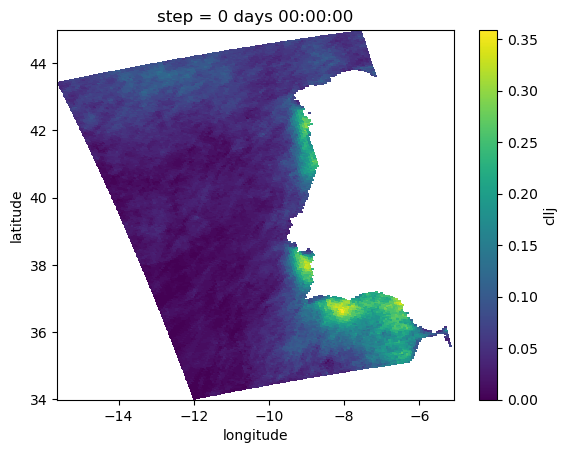

In [32]:
core_wind = ws.max(dim='heightAboveGround')
core_height = ws.heightAboveGround.isel(heightAboveGround=ws.argmax('heightAboveGround'))
masked_core_wind = core_wind.where(cllj_detection).where(lsm.data == 0)
masked_core_height = core_height.where(cllj_detection).where(lsm.data == 0)
(cllj_detection.cllj.sum(dim='time')/len(cllj_detection.time)).where(lsm.data==0).plot(x='longitude',y='latitude',col_wrap=3)

In [54]:
def map_plotter(gs,data,x,y,levels,cmap,title,shrink,colorbar,cbar_label,orientation,extent=None,rectangles=None,sample_points=None,fontsize=None,pad=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()

    contour = data.plot.contourf(
        x=x,y=y,levels=levels,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':fontsize},
        ax=ax)
    
    # Add colorbar with font size
    if colorbar:
        cbar = fig.colorbar(contour, orientation=orientation, shrink=shrink, aspect=40, label=cbar_label,pad=pad)
        cbar.ax.tick_params(labelsize=fontsize)
        if orientation == 'horizontal':
            cbar.ax.set_xlabel(cbar_label, fontsize=fontsize)
            cbar.ax.xaxis.set_label_position('top')
        else:
            cbar.ax.set_ylabel(cbar_label, fontsize=fontsize)
            cbar.ax.yaxis.set_label_position('left')
            
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    
    # set title
    ax.set_title(title,fontsize=fontsize)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=fontsize, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    
    if rectangles:
        target_grid = {'min_lat': 41.25, 'min_lon': -9.35,'max_lat':41.8,'max_lon':-8.65}
        # Draw a rectangular boxes
        min_lon = target_grid['min_lon']
        min_lat = target_grid['min_lat']
        max_lon = target_grid['max_lon']
        max_lat = target_grid['max_lat']
        rect = matplotlib.patches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                        linestyle='--', linewidth=1, edgecolor='red', facecolor='none',zorder=10)
        ax.add_patch(rect)
        
    return ax

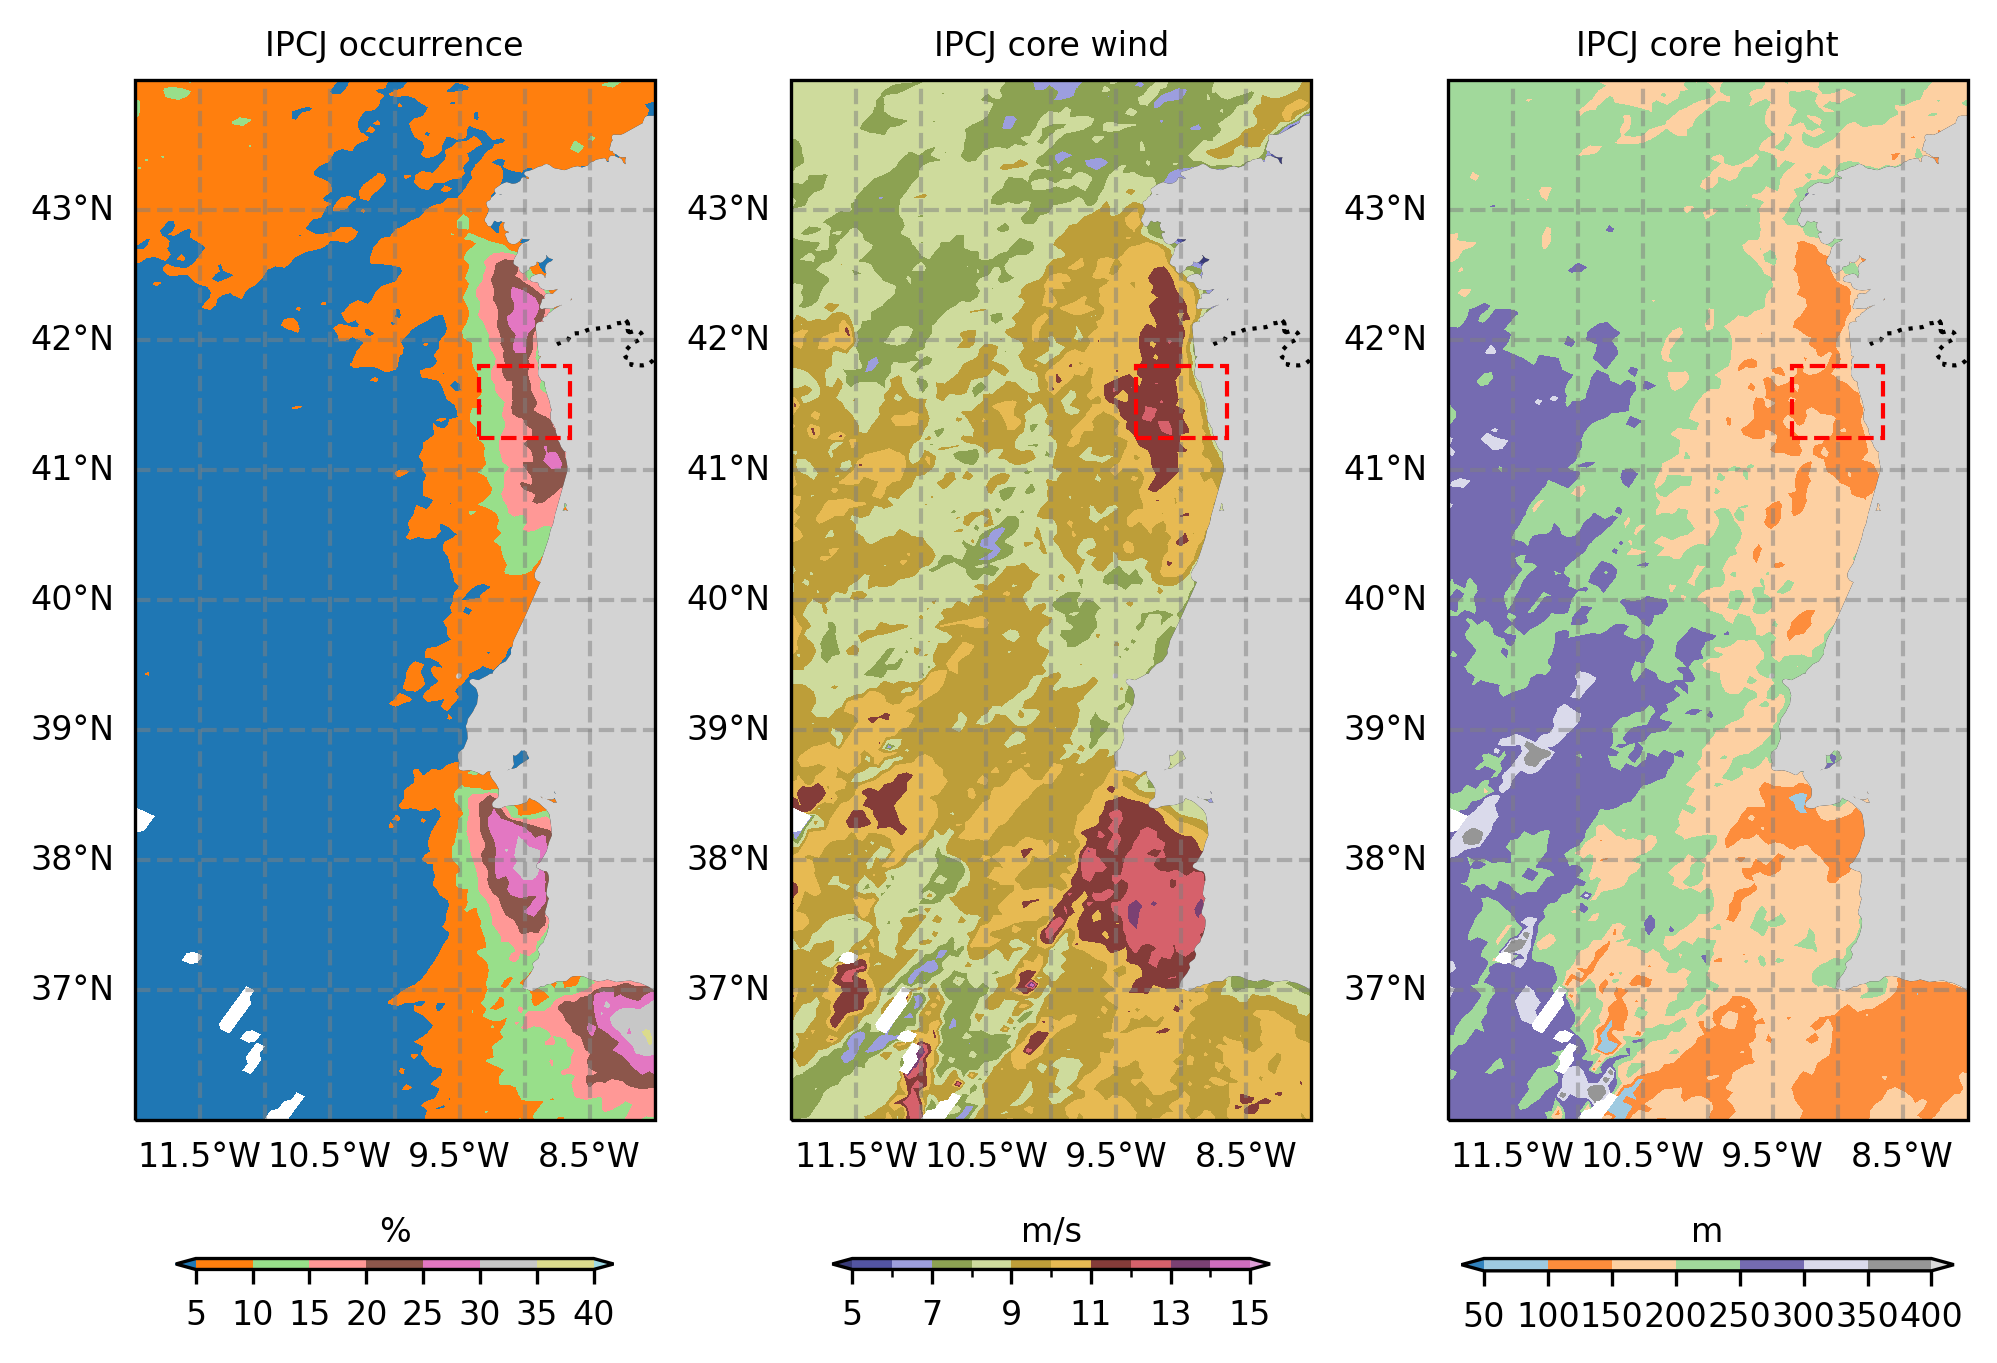

In [63]:
cllj_freq = cllj_detection.cllj.sum(dim='time')*100/len(cllj_detection.time)
core_wind = ws.max(dim='heightAboveGround')
core_height = ws.heightAboveGround.isel(heightAboveGround=ws.argmax('heightAboveGround'))

fig = plt.figure(figsize=(8,6), dpi=300)
gs = matplotlib.gridspec.GridSpec(1, 3)
extent = [-12, -8, 36, 44]
data = cllj_freq.where(cllj_freq>0)
map_plotter(gs[0],data,x='longitude',y='latitude',levels=np.arange(5,40.1,5),cmap='tab20',
            title='IPCJ occurrence',shrink=0.8,colorbar=True,cbar_label='%',
            orientation='horizontal',extent=extent,rectangles=True,fontsize=8,pad=0.1)

data = core_wind.where(cllj_detection.cllj).mean(dim='time')
map_plotter(gs[1],data,x='longitude',y='latitude',levels=np.arange(5,15.1,1),cmap='tab20b',
            title='IPCJ core wind',shrink=0.8,colorbar=True,cbar_label='m/s',
            orientation='horizontal',extent=extent,rectangles=True,fontsize=8,pad=0.1)

data = core_height.where(cllj_detection.cllj).mean(dim='time')
map_plotter(gs[2],data,x='longitude',y='latitude',levels=np.arange(50,400.1,50),cmap='tab20c',
            title='IPCJ core height',shrink=0.9,colorbar=True,cbar_label='m',
            orientation='horizontal',extent=extent,rectangles=True,fontsize=8,pad=0.1)
plt.savefig(f'/home/harish/Dropbox/Apps/Overleaf/Assessment of Wind Energy Resources for Portugal at Super-Scale Resolution/IPCJ_occurrence_core_wind_core_height_July_2007.pdf')

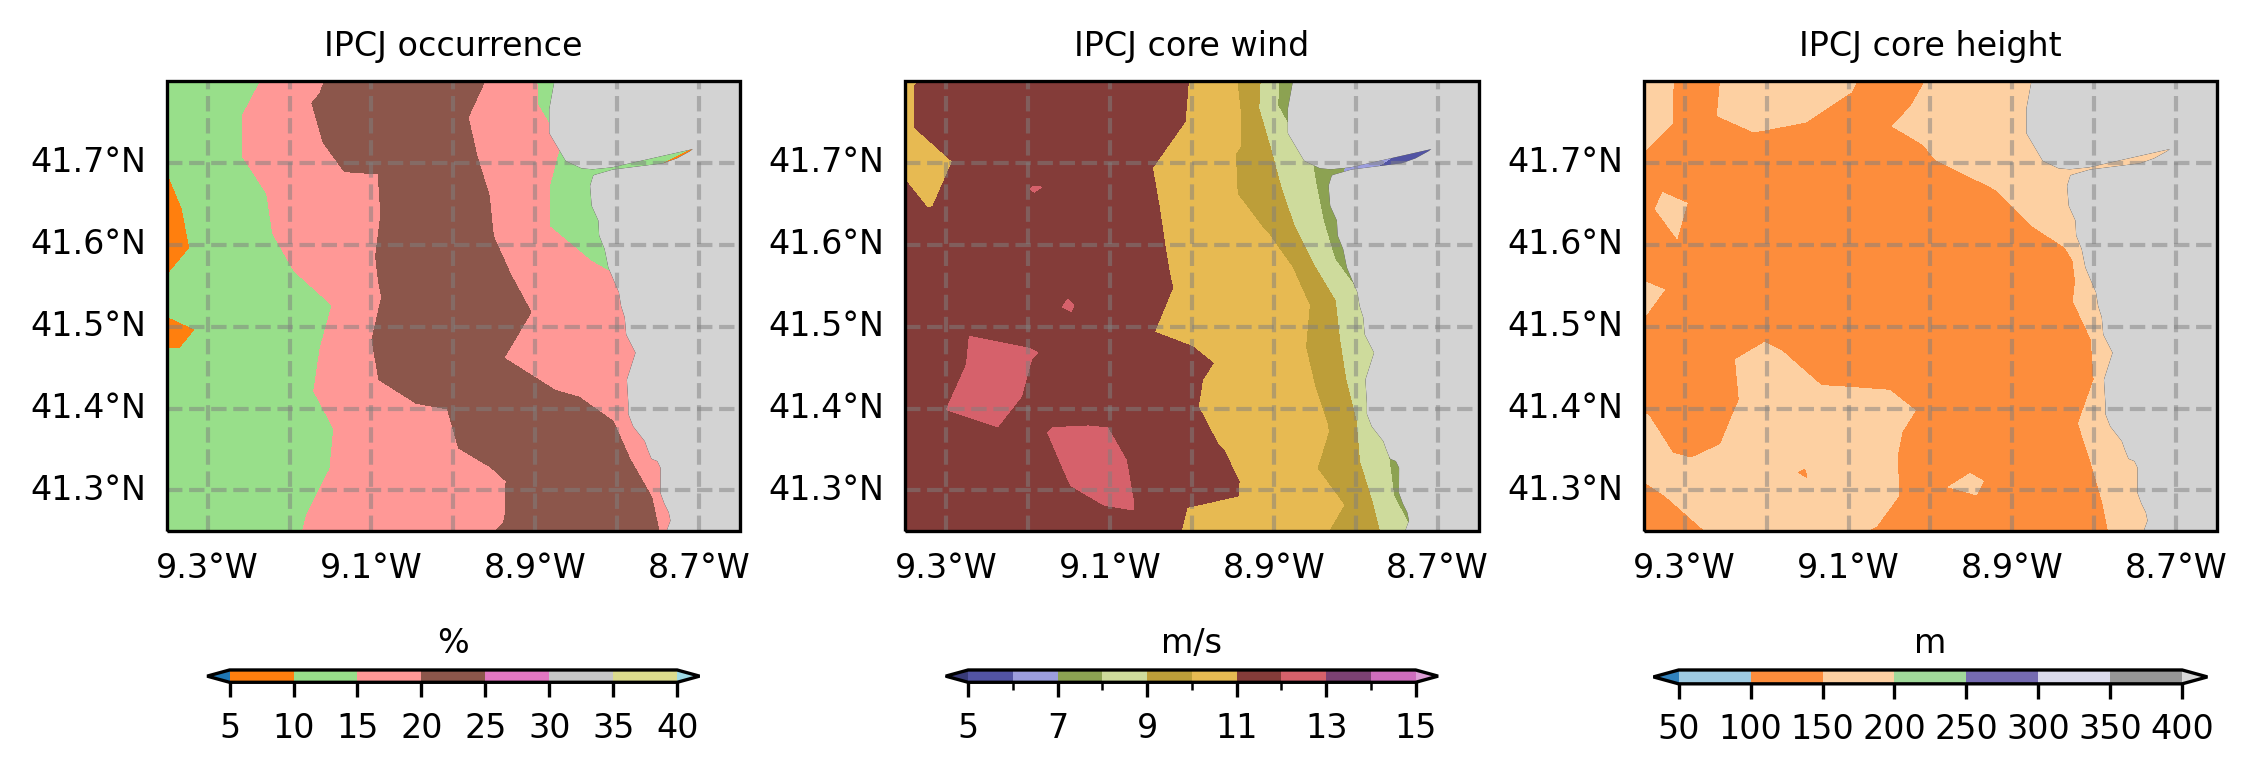

In [64]:
cllj_freq = cllj_detection.cllj.sum(dim='time')*100/len(cllj_detection.time)
core_wind = ws.max(dim='heightAboveGround')
core_height = ws.heightAboveGround.isel(heightAboveGround=ws.argmax('heightAboveGround'))

fig = plt.figure(figsize=(9,3), dpi=300)
gs = matplotlib.gridspec.GridSpec(1, 3)
extent = [-9.35, -8.65, 41.25, 41.8]
data = cllj_freq.where(cllj_freq>0)
map_plotter(gs[0],data,x='longitude',y='latitude',levels=np.arange(5,40.1,5),cmap='tab20',
            title='IPCJ occurrence',shrink=0.8,colorbar=True,cbar_label='%',
            orientation='horizontal',extent=extent,rectangles=False,fontsize=8,pad=0.2)

data = core_wind.where(cllj_detection.cllj).mean(dim='time')
map_plotter(gs[1],data,x='longitude',y='latitude',levels=np.arange(5,15.1,1),cmap='tab20b',
            title='IPCJ core wind',shrink=0.8,colorbar=True,cbar_label='m/s',
            orientation='horizontal',extent=extent,rectangles=False,fontsize=8,pad=0.2)

data = core_height.where(cllj_detection.cllj).mean(dim='time')
map_plotter(gs[2],data,x='longitude',y='latitude',levels=np.arange(50,400.1,50),cmap='tab20c',
            title='IPCJ core height',shrink=0.9,colorbar=True,cbar_label='m',
            orientation='horizontal',extent=extent,rectangles=False,fontsize=8,pad=0.2)
plt.savefig(f'/home/harish/Dropbox/Apps/Overleaf/Assessment of Wind Energy Resources for Portugal at Super-Scale Resolution/IPCJ_occurrence_core_wind_core_height_July_2007_forussed_region.pdf')

- It is clear that the there exist an optimum region suitable for wind power productin 
- where jet height is between 100-150 m
- Jet wind speed is 

# Analysis on the EU-SCORES data

# Analysis using ERA5 model level data

In [ ]:
ERA5_uvtq = xr.open_dataset(f"{root_dir}/ERA5-ml-u-v-t-subarea_.nc")
ERA5_zlnsp = xr.open_dataset(f"{root_dir}/ERA5-ml-lnsp-g-subarea.nc")

In [ ]:
#Calculation of geopotential and height
def calculategeoh(z, lnsp, ts, qs, levels):
    heighttoreturn=np.full(ts.shape[0], -999, np.double)
    geotoreturn=np.full(ts.shape[0], -999, np.double)

    Rd = 287.06

    z_h = 0
        
    #surface pressure
    sp = math.exp(lnsp)

    # A and B parameters to calculate pressures for model levels, 
    #  extracted from an ECMWF ERA-Interim GRIB file and then hardcoded here
    pv =  [
        0, 2.000365, 3.102241, 4.666084, 6.827977, 9.746966, 13.605424, 18.608931, 24.985718, 32.98571, 42.879242, 54.955463,
        69.520576, 86.895882, 107.415741, 131.425507, 159.279404, 191.338562, 227.968948, 269.539581, 316.420746, 368.982361,
        427.592499, 492.616028, 564.413452, 643.339905, 729.744141, 823.967834, 926.34491, 1037.201172, 1156.853638, 1285.610352,
        1423.770142, 1571.622925, 1729.448975, 1897.519287, 2076.095947, 2265.431641, 2465.770508, 2677.348145, 2900.391357,
        3135.119385, 3381.743652, 3640.468262, 3911.490479, 4194.930664, 4490.817383, 4799.149414, 5119.89502, 5452.990723,
        5798.344727, 6156.074219, 6526.946777, 6911.870605, 7311.869141, 7727.412109, 8159.354004, 8608.525391, 9076.400391,
        9562.682617, 10065.97852, 10584.63184, 11116.66211, 11660.06738, 12211.54785, 12766.87305, 13324.66895, 13881.33106,
        14432.13965, 14975.61523, 15508.25684, 16026.11523, 16527.32227, 17008.78906, 17467.61328, 17901.62109, 18308.43359,
        18685.71875, 19031.28906, 19343.51172, 19620.04297, 19859.39063, 20059.93164, 20219.66406, 20337.86328, 20412.30859,
        20442.07813, 20425.71875, 20361.81641, 20249.51172, 20087.08594, 19874.02539, 19608.57227, 19290.22656, 18917.46094,
        18489.70703, 18006.92578, 17471.83984, 16888.6875, 16262.04688, 15596.69531, 14898.45313, 14173.32422, 13427.76953,
        12668.25781, 11901.33984, 11133.30469, 10370.17578, 9617.515625, 8880.453125, 8163.375, 7470.34375, 6804.421875,
        6168.53125, 5564.382813, 4993.796875, 4457.375, 3955.960938, 3489.234375, 3057.265625, 2659.140625, 2294.242188,
        1961.5, 1659.476563, 1387.546875, 1143.25, 926.507813, 734.992188, 568.0625, 424.414063, 302.476563, 202.484375,
        122.101563, 62.78125, 22.835938, 3.757813, 0, 0, 0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.000007, 0.000024, 0.000059, 0.000112, 0.000199, 0.00034, 0.000562, 0.00089, 
        0.001353, 0.001992, 0.002857, 0.003971, 0.005378, 0.007133, 0.009261, 0.011806, 0.014816, 0.018318, 0.022355, 
        0.026964, 0.032176, 0.038026, 0.044548, 0.051773, 0.059728, 0.068448, 0.077958, 0.088286, 0.099462, 0.111505, 
        0.124448, 0.138313, 0.153125, 0.16891, 0.185689, 0.203491, 0.222333, 0.242244, 0.263242, 0.285354, 0.308598, 
        0.332939, 0.358254, 0.384363, 0.411125, 0.438391, 0.466003, 0.4938, 0.521619, 0.549301, 0.576692, 0.603648, 
        0.630036, 0.655736, 0.680643, 0.704669, 0.727739, 0.749797, 0.770798, 0.790717, 0.809536, 0.827256, 0.843881, 
        0.859432, 0.873929, 0.887408, 0.8999, 0.911448, 0.922096, 0.931881, 0.94086, 0.949064, 0.95655, 0.963352, 
        0.969513, 0.975078, 0.980072, 0.984542, 0.9885, 0.991984, 0.995003, 0.99763, 1
    ]
    levelSize=137
    A = pv[0:levelSize+1]
    B = pv[levelSize+1:]

    Ph_levplusone = A[levelSize] + (B[levelSize]*sp)

    #Get a list of level numbers in reverse order
    reversedlevels=np.full(levels.shape[0], -999, np.int32)
    for iLev in list(reversed(range(levels.shape[0]))):
        reversedlevels[levels.shape[0] - 1 - iLev] = levels[iLev]
            
    #Integrate up into the atmosphere from lowest level
    for lev in reversedlevels:
        #lev is the level number 1-60, we need a corresponding index into ts and qs
        ilevel=np.where(levels==lev)[0]
        t_level=ts[ilevel]
        q_level=qs[ilevel]

        #compute moist temperature
        t_level = t_level * (1.+0.609133*q_level)

        #compute the pressures (on half-levels)
        Ph_lev = A[lev-1] + (B[lev-1] * sp)

        if lev == 1:
            dlogP = math.log(Ph_levplusone/0.1)
            alpha = math.log(2)
        else:
            dlogP = math.log(Ph_levplusone/Ph_lev)
            dP    = Ph_levplusone-Ph_lev
            alpha = 1. - ((Ph_lev/dP)*dlogP)

        TRd = t_level*Rd

        # z_f is the geopotential of this full level
        # integrate from previous (lower) half-level z_h to the full level
        z_f = z_h + (TRd*alpha) 

        #Convert geopotential to height 
        heighttoreturn[ilevel] = z_f / 9.80665
            
        #Geopotential (add in surface geopotential)
        geotoreturn[ilevel] = z_f + z

        # z_h is the geopotential of 'half-levels'
        # integrate z_h to next half level
        z_h=z_h+(TRd*dlogP) 

        Ph_levplusone = Ph_lev
    return heighttoreturn 

def paralize_calculategeoh(z,lnsp,ts,qs,dim='level'):
    print(z.shape,lnsp.shape,ts.shape,qs.shape)
    levels = ts.coords[dim]

    # Apply the detect_CLLJ_per_point function across the dataset using Dask
    heighttoreturn = xr.apply_ufunc(
        calculategeoh,
        z,
        lnsp,
        ts,
        qs,
        levels,
        input_core_dims=[[],[],[dim], [dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.double],
        output_sizes={'level': ERA5_uvtq['level'].size}
    )
    
    return heighttoreturn


z_chunk = ERA5_zlnsp.z.chunk({'time':1,'latitude': 8, 'longitude': 8})
lnsp_chunk = ERA5_zlnsp.lnsp.chunk({'time':1,'latitude': 8, 'longitude': 8})
ts_chunk = ERA5_uvtq.t.chunk({'time':1,'latitude': 8, 'longitude': 8})
qs_chunk = ERA5_uvtq.q.chunk({'time':1,'latitude': 8, 'longitude': 8})

heighttoreturn = paralize_calculategeoh(z_chunk,lnsp_chunk,ts_chunk,qs_chunk).compute()

(72, 81, 161) (72, 81, 161) (72, 21, 81, 161) (72, 21, 81, 161)


/tmp/ipykernel_3832959/2441848724.py:97: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  heighttoreturn = xr.apply_ufunc(


In [ ]:
# Assign the height coordinate
wind_speed = np.sqrt(ERA5_uvtq.u**2+ERA5_uvtq.v**2)
temperature = ERA5_uvtq.t

wind_speed = wind_speed.assign_coords(height=heighttoreturn)
temperature = temperature.assign_coords(height= heighttoreturn)

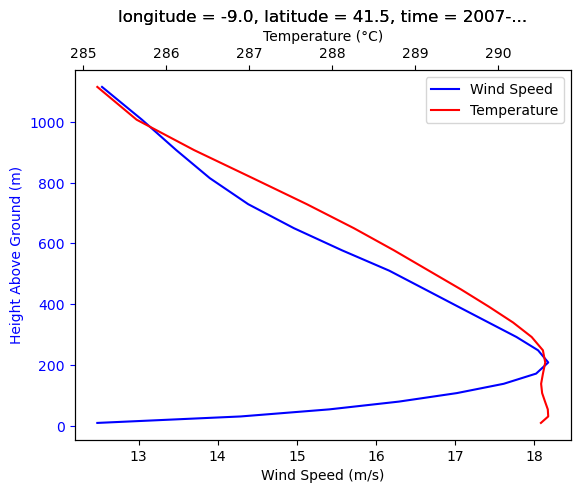

In [ ]:
wind_speed = wind_speed.sel(time='2007-08-19T15',latitude=P2[0],longitude=P2[1],method='nearest')
temperature = temperature.sel(time='2007-08-19T15').sel(latitude=P2[0],longitude=P2[1],method='nearest')

# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot wind speed with bottom x-axis
wind_speed.plot(ax=ax1, y='height', label='Wind Speed', color='b')
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Height Above Ground (m)', color='b')
ax1.tick_params('y', colors='b')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twiny()

# Plot temperature with top x-axis
temperature.plot(ax=ax2, y='height', label='Temperature', color='r')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Height Above Ground (m)', color='r')
ax2.tick_params('y', colors='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='best')

# Show plot
plt.show()